In [4]:
import scanpy as sc
import matplotlib.pyplot as pl
import seaborn as sns
import pandas as pd
import numpy as np
import sys
import scvelo as scv
from pathlib import Path

# Paths and utils
root = Path('../')
figure_path = root / 'results/figures/Neutrophils/'
figure_path.mkdir(parents=True, exist_ok=True)
table_path = root / 'results/tables/'
signatures_path = root / 'resources/'
import yaml
with open('../configuration/config.yaml', 'r') as file:
    config = yaml.safe_load(file)
data_path = Path(config['data_path'])
# local utils
sys.path.insert(1, '../utils/')
from utils import *

# Set plotting style
from matplotlib import rcParams
# Type 2/TrueType fonts
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
# Arial font
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "sans-serif"
%matplotlib inline

# Hamster only

In [2]:
superdata = sc.read(data_path / "Pancov19_prepd_all.h5")

# Import color options
import yaml
with open(root / 'config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)
celltype_colors = config['celltype_colors']
celltype_rough_colors = config['celltype_rough_colors']
organism_colors = config['organism_colors']
organism_dosage_colors = config['organism_dosage_colors']
dosage_colors = config['dosage_colors']

# Newer names, more accurate
organism_rename_dict = {
    'Dwarfhamster': 'Roborovski hamster',
    'Goldhamster': 'Syrian hamster'
}
time_rename_dict = {
    'D0': '0 dpi',
    'D2': '2 dpi',
    'D3': '3 dpi',
    'D5': '5 dpi',
    'E14': '14 dpi'
}
dosage_rename_dict = {
    'no dose': '0 pfu',
    'low dose': r'1x10$^4$ pfu',
    'high dose': r'1x10$^5$ pfu'
}

def sanitize_name(s):
    for rdict in [organism_rename_dict, time_rename_dict, dosage_rename_dict]:
        for old, new in rdict.items():
            s = s.replace(old, new)
            
    return s.replace('_', ', ')

from matplotlib.cm import get_cmap
# not super pretty, but ok for now
time_colors = {
    'D0': 'grey',
    'D2': get_cmap('viridis_r')(0),
    'D3': get_cmap('viridis_r')(1/3),
    'D5': get_cmap('viridis_r')(2/3),
    'E14': get_cmap('viridis_r')(1-0.00000001),
              }
    
# Translate color palettes to new names as well
Organism_colors = {sanitize_name(key) : value for key, value in config['organism_colors'].items()}
Organism_Dosage_colors = {sanitize_name(key) : value for key, value in config['organism_dosage_colors'].items()}
Dosage_colors = {sanitize_name(key) : value for key, value in config['dosage_colors'].items()}
Time_colors = {sanitize_name(key) : value for key, value in time_colors.items()}

# celltype mid resolution
celltype_mid_colors = celltype_rough_colors.copy()
celltype_mid_colors['AT1'] = celltype_colors['AT1']
celltype_mid_colors['AT2'] = celltype_colors['AT2']
celltype_mid_colors['Ciliated'] = celltype_colors['Ciliated']
superdata.obs['celltype_mid'] = superdata.obs['celltype_rough'].astype(str)
mask = superdata.obs['celltype_mid'] == 'Epithelial cells'
superdata.obs['celltype_mid'][mask] = superdata.obs['celltype'][mask]

# define control dicts for DE testing etc.
control_dict = {x: ['pr_D0_Z1_L','pr_D0_Z2_L','pr_D0_Z3_L'] if 'pr' in x else ['ma_d0_lung_1', 'ma_d0_lung_2', 'ma_d0_lung_3'] for x in pd.unique(superdata.obs['orig.ident']) if '0' not in x}
control_dict_odt = {x: 'Dwarfhamster_no dose_D0' if 'Dwarfhamster' in x else 'Goldhamster_no dose_D0' for x in superdata.obs.organism_dosage_time.unique() if 'D0' not in x}

## Umaps (Fig1B and FigS1B)

In [3]:
fig_kwargs = {'dpi': 300, 'figsize': [8,6], 'title': '', 'show': False, 
              'basis': 'umap_scVI', 'adata': superdata, 'legend_fontsize': 10}

In [4]:
# plot with text for pdf
for key in ['celltype', 'celltype_mid', 'celltype_rough', 'Dosage', 'Organism', 'Time', 'Organism_Dosage']:
    for legend_loc in ['right margin', 'on data']:
        scv.pl.scatter(color=key, legend_loc=legend_loc, palette=eval(f'{key}_colors'), **fig_kwargs)
        pl.savefig(figure_path / f'Hamsters_umap_{key.lower()}_{legend_loc}.pdf',
                    bbox_inches='tight')
        pl.close()
    scv.pl.scatter(color=key, legend_loc=False, palette=eval(f'{key}_colors'), **fig_kwargs)
    pl.savefig(figure_path / f'Hamsters_umap_{key.lower()}_notext.png',
                bbox_inches='tight', transparent=True)
    pl.close()
        

In [5]:
# plot with text for pdf (alternative, with bigger dots)
# only for celltype coloring, since otherwise overplotting becomes a problem.
for key in ['celltype', 'celltype_mid']:
    for legend_loc in ['right margin', 'on data']:
        scv.pl.scatter(color=key, legend_loc=legend_loc, palette=eval(f'{key}_colors'), s=10, **fig_kwargs)
        pl.savefig(figure_path / f'Hamsters_umap_{key.lower()}_alternative_{legend_loc}.pdf',
                    bbox_inches='tight')
        pl.close()
    scv.pl.scatter(color=key, legend_loc=False, palette=eval(f'{key}_colors'), s=10, **fig_kwargs)
    pl.savefig(figure_path / f'Hamsters_umap_{key.lower()}_alternative_notext.png',
                bbox_inches='tight', transparent=True)
    pl.close()
        

## QC plots (FigS1C)

In [27]:
order = [
    'ma_d0_lung_1',
    'ma_d0_lung_2',
    'ma_d0_lung_3',
    'ma_d2_lung_1',
    'ma_d2_lung_2',
    'ma_d2_lung_3',
    'ma_d3_lung_1',
    'ma_d3_lung_2',
    'ma_d3_lung_3',
    'ma_d5_lung_1',
    'ma_d5_lung_2',
    'ma_d5_lung_3',
    'ma_e14_lung_1',
    'ma_e14_lung_2',
    'ma_e14_lung_3',
    'pr_D0_Z1_L',
    'pr_D0_Z2_L',
    'pr_D0_Z3_L',
    'pr_ld_D2_Z1_L',
    'pr_ld_D2_Z2_L',
    'pr_ld_D2_Z3_L',
    'pr_ld_D3_Z1_L',
    'pr_ld_D3_Z2_L',
    'pr_ld_D3_Z3_L',
    'pr_hd_D2_Z1_L',
    'pr_hd_D2_Z2_L',
    'pr_hd_D2_Z3_L',
    'pr_hd_D3_Z1_L',
    'pr_hd_D3_Z2_L',
    'pr_hd_D3_Z3_L',
]

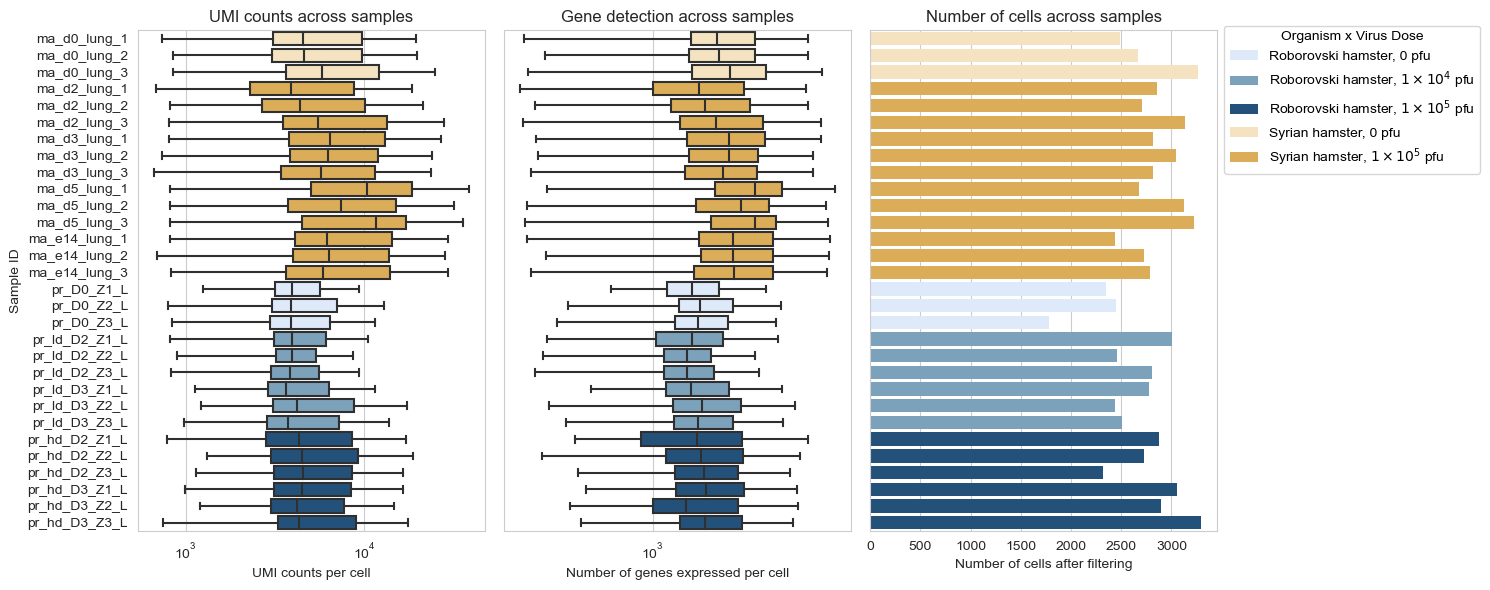

In [31]:
df = superdata.obs.copy()
N = 3
with sns.axes_style('whitegrid'):
    fig, axs = pl.subplots(1, N, figsize=[5*N,6], sharey=True)

kwargs = dict(palette=Organism_Dosage_colors, dodge=False, order=order,
              y = 'orig.ident', hue='Organism_Dosage')

ax = axs[0]
sns.boxplot(data=df, x='nCount_RNA', ax=ax, showfliers=False,**kwargs)
ax.legend([],[], frameon=False)
ax.set_xscale('log')
ax.set_ylabel('Sample ID')
ax.set_xlabel('UMI counts per cell')
ax.set_title('UMI counts across samples')

ax = axs[1]
sns.boxplot(data=df, x='nFeature_RNA', ax=ax, showfliers=False, **kwargs)
ax.legend([],[], frameon=False)
ax.set_xscale('log')
ax.set_ylabel('')
ax.set_xlabel('Number of genes expressed per cell')
ax.set_title('Gene detection across samples')

ax = axs[2]
sns.barplot(data=df.value_counts(['Organism_Dosage', 'orig.ident'], sort=False).reset_index(), 
            x=0, ax=ax, linewidth=10, **kwargs)
ax.legend(bbox_to_anchor=(1,.7), title='Organism x Virus Dose')
ax.set_xscale('linear')
ax.set_ylabel('')
ax.set_xlabel('Number of cells after filtering')
ax.set_title('Number of cells across samples')

pl.tight_layout()
pl.savefig(figure_path / 'Hamsters_sequencing_QC_boxplots_OxD.pdf', bbox_inches='tight')
pl.show()

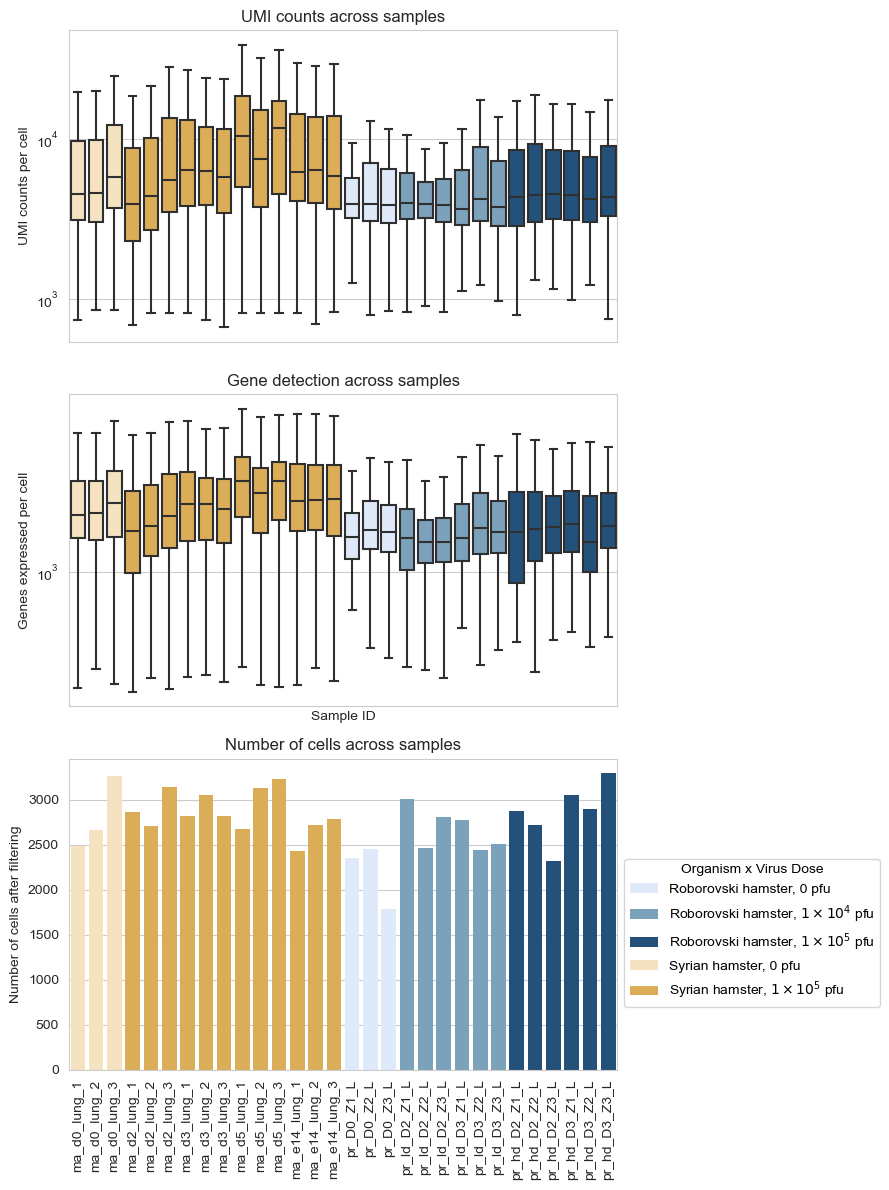

In [33]:
df = superdata.obs.copy()
with sns.axes_style('whitegrid'):
    fig, axs = pl.subplots(3, 1, figsize=[9,4*3], sharex=True)

kwargs = dict(palette=Organism_Dosage_colors, dodge=False, order=order,
              x = 'orig.ident', hue='Organism_Dosage')

ax = axs[0]
sns.boxplot(data=df, y='nCount_RNA', ax=ax, showfliers=False, **kwargs)
ax.legend([],[], frameon=False)
ax.set_yscale('log')
ax.set_xlabel('')
ax.set_ylabel('UMI counts per cell')
ax.set_title('UMI counts across samples')

ax = axs[1]
sns.boxplot(data=df, y='nFeature_RNA', ax=ax, showfliers=False, **kwargs)
ax.legend([],[], frameon=False)
ax.set_yscale('log')
ax.set_xlabel('Sample ID')
ax.set_ylabel('Genes expressed per cell')
ax.set_title('Gene detection across samples')

ax = axs[2]
sns.barplot(data=df.value_counts(['Organism_Dosage', 'orig.ident'], sort=False).reset_index(), 
            y=0, ax=ax, linewidth=10, **kwargs)
ax.legend(bbox_to_anchor=(1,.7), title='Organism x Virus Dose')
ax.set_yscale('linear')
ax.set_xlabel('')
ax.set_ylabel('Number of cells after filtering')
ax.set_title('Number of cells across samples')

pl.xticks(rotation=90)
pl.tight_layout()
pl.savefig(figure_path / 'Hamsters_sequencing_QC_boxplots_OxD_horizontal.pdf', bbox_inches='tight')
pl.show()

## Cell proportions bars (FigS1D)

In [6]:
y = 'Organism_Dosage_Time'
df = superdata.obs.copy()
adf = df.value_counts(['celltype_mid', y], sort=False)

In [7]:
# 10 times more Neutrophils at HD D2/3 than in D0
adf['Neutrophils'].iloc[:5] / adf['Neutrophils'].iloc[0]

Organism_Dosage_Time
Roborovski hamster, 0 pfu, 0 dpi            1.000000
Roborovski hamster, 1x10$^4$ pfu, 2 dpi     6.972527
Roborovski hamster, 1x10$^4$ pfu, 3 dpi     4.000000
Roborovski hamster, 1x10$^5$ pfu, 2 dpi    10.104396
Roborovski hamster, 1x10$^5$ pfu, 3 dpi    10.274725
dtype: float64

In [8]:
celltype_mid_order = ['AT1', 'AT2', 'Ciliated',
                  'Fibroblasts', 'Myofibroblast', 'SmoothMuscle',
                  'Endothelial cells', # 'Artery', 'Bronchial', 'Lymphatic', 'Capillary', 'Vein', 
                  'Plasma cells', 'Bcells', 
                  'T cells',  # 'CD4+ T cells', 'CD8+ T cells', 'activated T cells', 
                  'NK cells', # includes 'NKT cells'
                  'ILC2', 
                  'Macrophages',  # 'AlveolarMacrophages', 'InterstitialMacrophages', 'MonocyticMacrophages', 'Treml4+Macrophages',
                  'Neutrophils', 'cDC', 'pDC', 'Platelets', 'Erythrocytes', 'Mast cells'
       ]

In [9]:
order = ['Syrian hamster, 0 pfu, 0 dpi', 
         'Syrian hamster, 1x10$^5$ pfu, 2 dpi', 
         'Syrian hamster, 1x10$^5$ pfu, 3 dpi', 
         'Syrian hamster, 1x10$^5$ pfu, 5 dpi', 
         'Syrian hamster, 1x10$^5$ pfu, 14 dpi', 
         'Roborovski hamster, 0 pfu, 0 dpi', 
         'Roborovski hamster, 1x10$^4$ pfu, 2 dpi', 
         'Roborovski hamster, 1x10$^4$ pfu, 3 dpi', 
         'Roborovski hamster, 1x10$^5$ pfu, 2 dpi', 
         'Roborovski hamster, 1x10$^5$ pfu, 3 dpi']

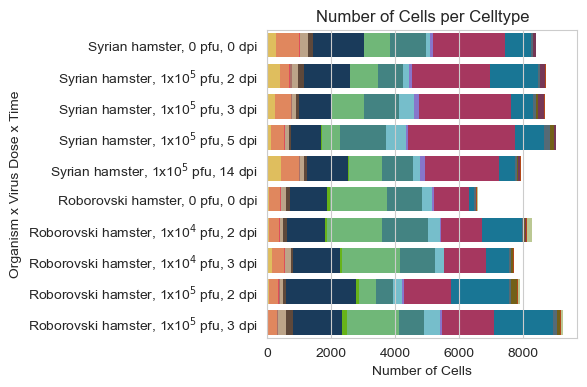

In [10]:
old = [0] * len(pd.unique(adf.reset_index()[y]))
colors = celltype_mid_colors
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(1,1, figsize=[4,4])
for i, celltype in enumerate(celltype_mid_order):
    xdf = adf.loc[celltype] + old
    sns.barplot(x=0, y=y, data = xdf.reset_index(), zorder=-i, color=colors[celltype], 
                order=order)
    old = xdf
pl.ylabel('Organism x Virus Dose x Time')
pl.xlabel('Number of Cells')
pl.title('Number of Cells per Celltype')
pl.savefig(figure_path / 'Hamsters_bar_ncellspercelltype_OxD.pdf', bbox_inches='tight')
pl.show()

## Virus sequences

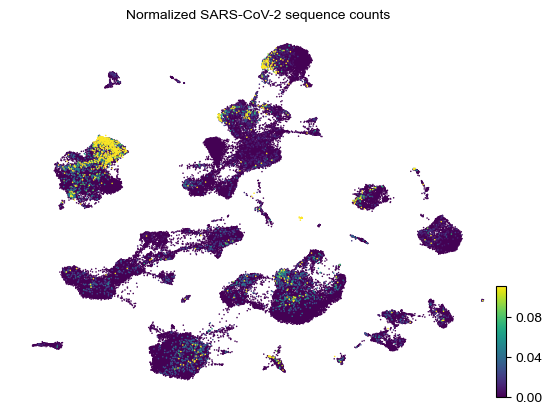

In [4]:
# UMAP
scv.pl.scatter(superdata, color='SCoV2_load', basis='umap_scVI', perc=[1, 99], 
               s=5, title='Normalized SARS-CoV-2 sequence counts', show=False)
pl.savefig(figure_path / 'FigS1X_Hamsters_umap_SCoV2_load.pdf', bbox_inches='tight')
pl.savefig(figure_path / 'FigS1X_Hamsters_umap_SCoV2_load.png', bbox_inches='tight', dpi=300)
pl.show()

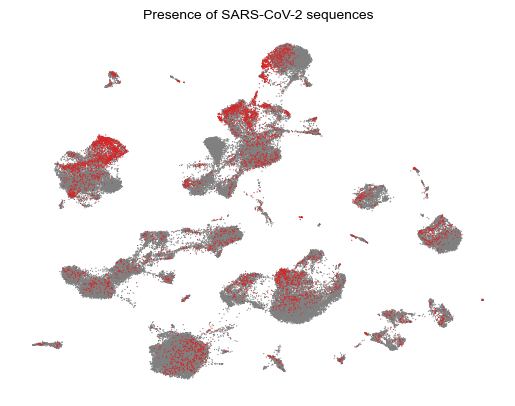

In [5]:
# UMAP
s = 3
ax = scv.pl.scatter(superdata[superdata.obs.SCoV2_detected==False], basis='umap_scVI',
               s=s, title='Presence of SARS-CoV-2 sequences', show=False, color='grey')
scv.pl.scatter(superdata[superdata.obs.SCoV2_detected==True], basis='umap_scVI', ax=ax,
               s=s, title='Presence of SARS-CoV-2 sequences', show=False, color='tab:red')
pl.savefig(figure_path / 'FigS1X_Hamsters_umap_SCoV2_detected.pdf', bbox_inches='tight')
pl.savefig(figure_path / 'FigS1X_Hamsters_umap_SCoV2_detected.png', bbox_inches='tight', dpi=300)
pl.show()

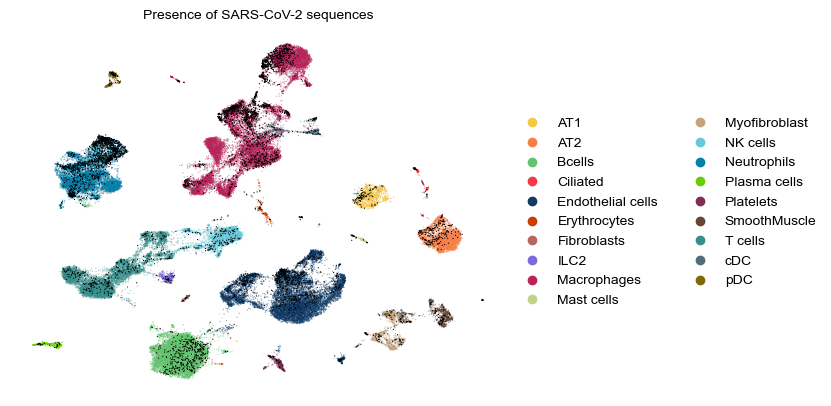

In [12]:
# UMAP celltype and virus
s = 3
ax = scv.pl.scatter(superdata[superdata.obs.SCoV2_detected==False], basis='umap_scVI', palette=celltype_mid_colors,
               s=s, title='Presence of SARS-CoV-2 sequences', show=False, color='celltype_mid', alpha=0.5, legend_loc='right margin')
scv.pl.scatter(superdata[superdata.obs.SCoV2_detected==True], basis='umap_scVI', ax=ax,
               s=s, title='Presence of SARS-CoV-2 sequences', show=False, color='black')
pl.savefig(figure_path / 'FigS1X_Hamsters_umap_SCoV2_detected_celltypes.pdf', bbox_inches='tight')
pl.savefig(figure_path / 'FigS1X_Hamsters_umap_SCoV2_detected_celltypes.png', bbox_inches='tight', dpi=300)
pl.show()

In [13]:
df = superdata.obs[['SCoV2_detected', 'SCoV2_load', 'Organism_Dosage_Time', 'orig.ident', 'Organism', 'Dosage', 'Time', 'celltype_mid']].copy()

In [14]:
freqs = df.value_counts(['Organism_Dosage_Time', 'celltype_mid', 'SCoV2_detected'], sort=False, dropna=False)
totals = freqs.sum(level=[0,1])
fraction_with_sequence = (freqs.loc[:, :, True] / totals).reset_index()
fraction_with_sequence = fraction_with_sequence[~fraction_with_sequence.Organism_Dosage_Time.str.contains('0 dpi')]

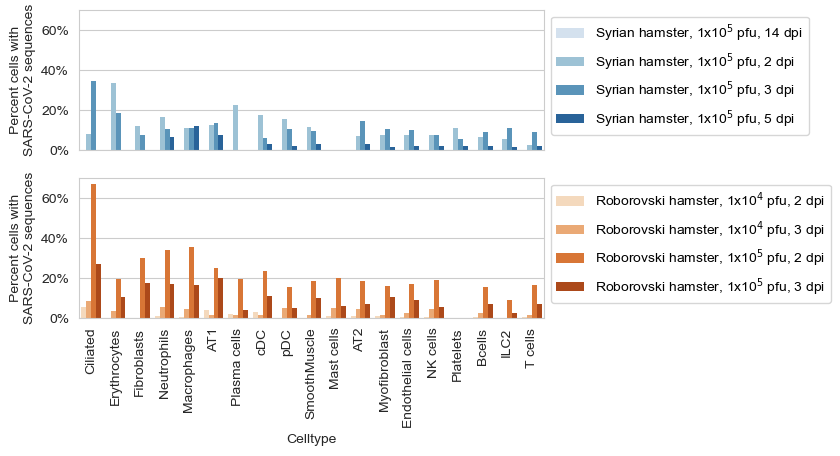

In [15]:
import matplotlib.ticker as mtick
with sns.axes_style('whitegrid'):
    fig, axs = pl.subplots(2,1, figsize=[6,4], sharex=True, sharey=True)
order = fraction_with_sequence.groupby('celltype_mid').mean().sort_values(by=0, ascending=False)
for ax, palette, str_key in zip(axs, ['Blues', 'Oranges'], ['Syria', 'Robo']):
    sdf=fraction_with_sequence[fraction_with_sequence.Organism_Dosage_Time.str.contains(str_key)]
    sns.barplot(data=sdf, x='celltype_mid', hue='Organism_Dosage_Time', y=0, 
                palette=palette, ax=ax, order=order.index)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    ax.set_ylabel('Percent cells with\nSARS-CoV-2 sequences')
    if ax==axs[-1]: ax.set_xlabel('Celltype')
    else: ax.set_xlabel('')
    ax.legend(bbox_to_anchor=(1,1))
pl.savefig(figure_path / 'FigS1X_Hamsters_barplot_SCoV2_percentages.pdf', bbox_inches='tight')
pl.show()

# Compare metadata across datasets

In [10]:
df = pd.read_csv(data_path / "joint_metadata.csv", index_col=0)
df = df[df['dataset'] != 'Wendisch']

## export metadata summary (e.g. sample sizes)

In [21]:
sdf = df.value_counts(['dataset', 'sample_id', 'sample_type', 'severity'], sort=False, dropna=False).reset_index().set_index('sample_id').rename(columns={0: 'cell_count'})
sdf.to_csv(table_path / 'Fig1_sample_infos.csv')

## signatures plotted in splits (Fig1F and Fig1G)

In [22]:
# define colors
palette_human = {x: 'tab:blue' if any(np.isin(['healthy', 'control', 'recovered'], x.split('_'))) 
           else 'tab:orange' if any(np.isin(['mild', 'moderate'], x.split('_')))
           else 'tab:red'  # severe and critical cases
           for x in df.temp.unique()}
palette_hamster = {
    'Goldhamster_healthy': organism_dosage_colors['Goldhamster_no dose'],
    'Goldhamster_infected': organism_dosage_colors['Goldhamster_high dose'],
    'Dwarfhamster_healthy': organism_dosage_colors['Dwarfhamster_no dose'],
    'Dwarfhamster_ld_infected': organism_dosage_colors['Dwarfhamster_low dose'],
    'Dwarfhamster_hd_infected': organism_dosage_colors['Dwarfhamster_high dose'],
}
PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

In [23]:
# OPTIONS
key ='HALLMARK_INFLAMMATORY_RESPONSE'  # x axis value
hue = 'temp'  # color by this
groupby = 'celltype'  # y axis value
scale = 0.92  # text to box ratio
wspace = 0.45  # space between subplots
xlims = (-0.12, 0.45)  # x axis limits jointly for all subplots

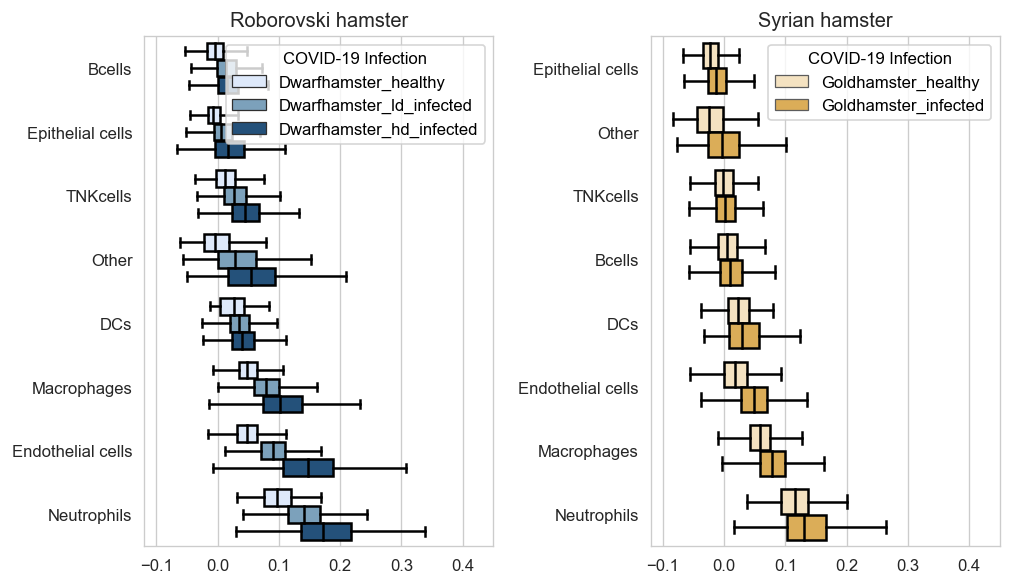

In [24]:
# Setup figure
with sns.axes_style('whitegrid'):
    axs = np.ravel(pl.subplots(1, 2, figsize=[5*2*scale,6*scale], dpi=120, sharex=True, sharey=False, gridspec_kw={'wspace': wspace})[-1])

# plot hamster data
for ax, dataset in zip(axs, ['Dwarfhamster', 'Goldhamster']):
    sdf = df[df.dataset==dataset]
    if 'Goldhamster' in dataset:
        # Goldhamster: remove D5 since we do not have that in Dwarf
        sdf = sdf[sdf.time.isin(['D0', 'D2', 'D3'])]
    elif dataset=='Dwarfhamster':
        # Add low and high dose to Dwarf
        sdf['temp'] = ['Dwarfhamster_hd_infected' if d=='high dose' else \
                            'Dwarfhamster_ld_infected' if d=='low dose' else \
                            'Dwarfhamster_healthy' for d in sdf.dosage]

    # Order of hue alphabetically by color (blue, orange, red)
    hues = sdf[hue].unique()
    hue_order = hues[np.argsort([palette_hamster[x] for x in hues])]
    if dataset=='Goldhamster':
        hue_order = ['Goldhamster_healthy','Goldhamster_infected']
    else:
        hue_order = ['Dwarfhamster_healthy','Dwarfhamster_ld_infected','Dwarfhamster_hd_infected']

    # Order celltypes by mean score
    order = sdf.groupby(groupby).mean()[key].sort_values().index

    # plot
    sns.boxplot(data=sdf, y=groupby, x=key, showfliers=False, order=order,
                hue=hue, dodge=True, ax=ax, palette=palette_hamster, hue_order=hue_order, **PROPS)

    # annotations
    ax.set_title(sanitize_name(dataset))
    ax.set_xlabel('')
    ax.legend(title='COVID-19 Infection')
    ax.set_ylabel('')
    ax.set_xlim(xlims)
pl.savefig(figure_path / f'Fig1F.pdf', bbox_inches='tight')
pl.show()

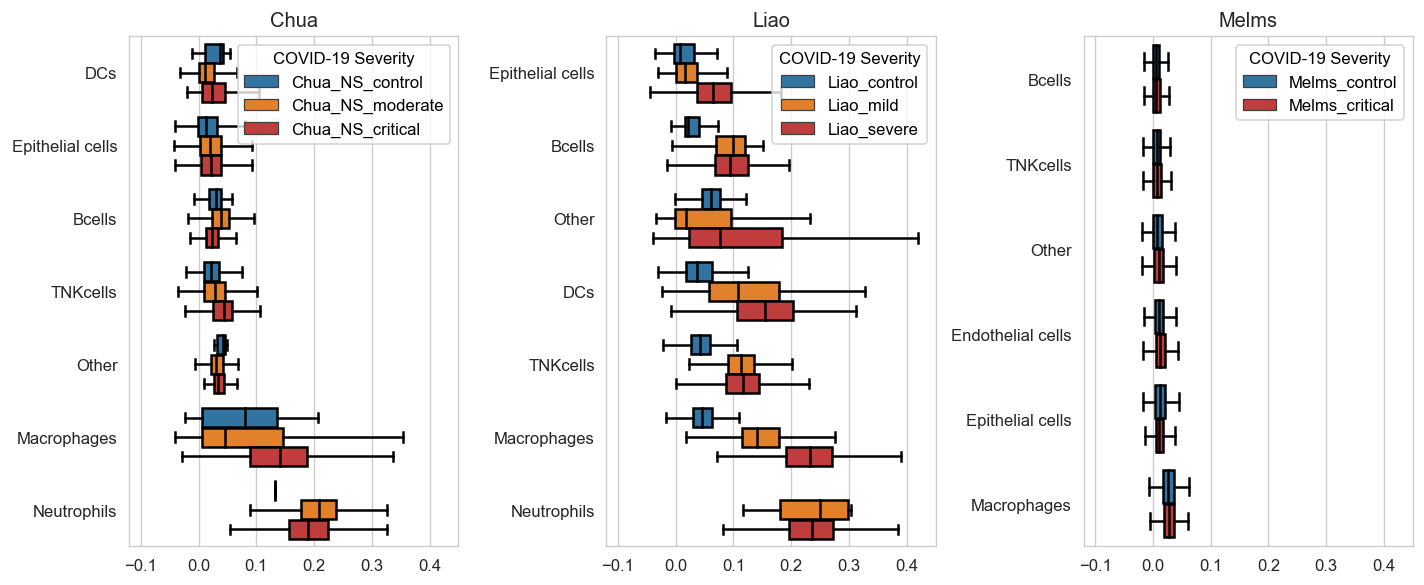

In [25]:
with sns.axes_style('whitegrid'):
    axs = np.ravel(pl.subplots(1, 3, figsize=[5*3*scale,6*scale], dpi=120, sharex=True, sharey=False, gridspec_kw={'wspace': wspace})[-1])

for ax, dataset in zip(axs, ['Chua', 'Liao', 'Melms']):
    sdf = df[df.dataset==dataset]

    # Chua: only NS samples
    if 'Chua' in dataset:
        sdf = sdf[sdf.sample_type=='Nasal Swap']

    # Order of hue alphabetically by color (blue, orange, red)
    hues = sdf[hue].unique()
    hue_order = hues[np.argsort([palette_human[x] for x in hues])]

    # Order celltypes by mean score
    order = sdf.groupby(groupby).mean()[key].sort_values().index

    # plot
    sns.boxplot(data=sdf, y=groupby, x=key, showfliers=False, order=order,
                hue=hue, dodge=True, ax=ax, palette=palette_human, hue_order=hue_order, **PROPS)

    # annotations
    ax.set_title(dataset)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend(title='COVID-19 Severity')
    ax.set_xlim(xlims)
pl.savefig(figure_path / f'Fig1G.pdf', bbox_inches='tight')
pl.show()

In [32]:
df[['dataset', 'temp', 'celltype', 'HALLMARK_INFLAMMATORY_RESPONSE']].to_csv(table_path / 'Fig1FG_source.csv')

## doughnuts (Fig1C and Fig1D)

In [33]:
# cleaner names
df.celltype = df.celltype.replace({'Bcells': 'B cells', 'TNKcells': 'T/NK cells', 'MyeloidDendritic': 'cDC'})

celltype_rough_colors['T/NK cells'] = celltype_rough_colors['T cells']
celltype_rough_colors['B cells'] = celltype_rough_colors['Bcells']

In [50]:
def layered_doughnut(df, groups_towards_center, groupby, palette, add_labels=False, colorby='celltype', r_min = 0, ax=None):
    cols = [colorby, 'dataset', groupby, 'sample_id']
    adf = df.value_counts(cols, sort=False)
    res = adf.reset_index()
    res.columns = cols + ['ncells']
    
    n_cells = res.groupby('sample_id').sum()
    res['freq'] = res.ncells.values / np.ravel(n_cells.loc[res.sample_id].values)
    
    # r_min: minimal radius (i.e. outer radius of the most inner ring)
    K = len(groups_towards_center)
    t = (1-r_min)/(K)  # thickness of a single ring

    F = {}
    ax = pl.subplots(1, 1, figsize=[6, 4], dpi=120)[-1] if ax is None else ax
    for group, r in zip(groups_towards_center, np.linspace(1, r_min+t, K)):
        freqs = res[res[groupby]==group].groupby(colorby).mean()['freq']
        F[group] = freqs
        ax.pie(freqs, labels=freqs.index if r==1 and add_labels else None, radius=r, wedgeprops={'linewidth': 2, 'edgecolor': 'w'},
               colors=[palette[idx] for idx in freqs.index])
        if group in ['D0', 'D2', 'D3', 'D5', 'E14']:
            group = group[1:]
        ax.annotate(group, (0, r-t/2), (1, r-t/2), arrowprops=dict(facecolor='black', arrowstyle="-", linewidth=2))
    ax.add_artist(pl.Circle( (0,0), r_min, color='white'))  # add empty, white circle in the middle
    ax.arrow(0,0,0,1.05, length_includes_head=False,
              head_width=.1, head_length=.1, color='k', lw=7)
    ax.set_title(f'Average cell frequency')
    return F

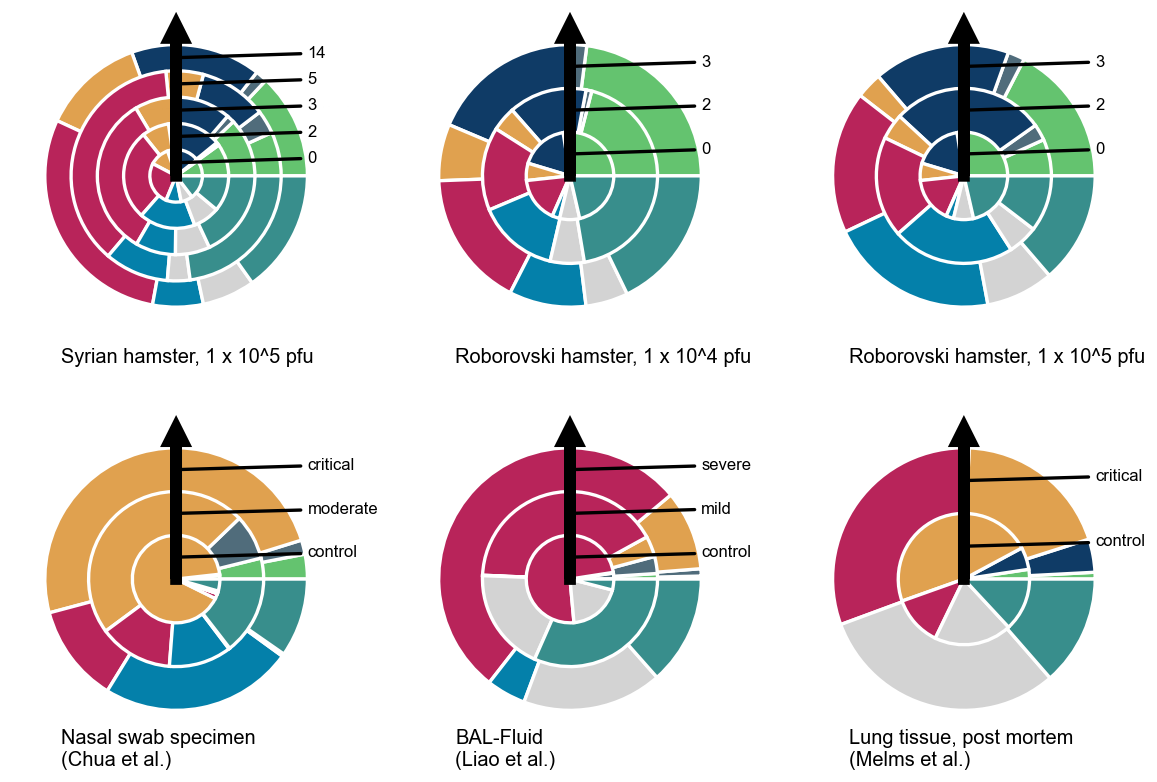

In [54]:
axs = np.ravel(pl.subplots(2, 3, figsize=[4*3, 4*2], dpi=120)[-1])
kwargs = {'palette': celltype_rough_colors}
title_kwargs = dict(y=-.1, ha='left', x=.15)
Fs = {}
Fs['Goldhamster'] = layered_doughnut(df[df.dataset=='Goldhamster'], groups_towards_center=['D0', 'D2', 'D3', 'D5', 'E14'][::-1], groupby='time', ax=axs[0], **kwargs)
axs[0].set_title('Syrian hamster, 1 x 10^5 pfu', **title_kwargs)
Fs['Dwarfhamster_ld'] = layered_doughnut(df[(df.dataset=='Dwarfhamster') & (df.dosage!='high dose')], groups_towards_center=['D3', 'D2', 'D0'], groupby='time', ax=axs[1], **kwargs)
axs[1].set_title('Roborovski hamster, 1 x 10^4 pfu', **title_kwargs)
Fs['Dwarfhamster_hd'] = layered_doughnut(df[(df.dataset=='Dwarfhamster') & (df.dosage!='low dose')], groups_towards_center=['D3', 'D2', 'D0'], groupby='time', ax=axs[2], **kwargs)
axs[2].set_title('Roborovski hamster, 1 x 10^5 pfu', **title_kwargs)
Fs['Chua_NS'] = layered_doughnut(df[(df.dataset=='Chua') & (df.sample_type=='Nasal Swap')], groups_towards_center=['critical', 'moderate', 'control'], groupby='severity', ax=axs[3], **kwargs)
axs[3].set_title('Nasal swab specimen\n(Chua et al.)', **title_kwargs)
Fs['Liao'] = layered_doughnut(df[df.dataset=='Liao'], groups_towards_center=['severe', 'mild', 'control'], groupby='severity', ax=axs[4], **kwargs)
axs[4].set_title('BAL-Fluid\n(Liao et al.)', **title_kwargs)
Fs['Melms'] = layered_doughnut(df[(df.dataset=='Melms')], groups_towards_center=['critical', 'control'], groupby='severity', ax=axs[5], **kwargs)
axs[5].set_title('Lung tissue, post mortem\n(Melms et al.)', **title_kwargs)
pl.savefig(figure_path / 'Fig1CD.pdf', bbox_inches='tight')
pl.show()

In [65]:
edf = pd.concat({k: pd.concat(Fs[k]) for k in Fs.keys()}).reset_index()
edf.columns = ['dataset', 'group', 'celltype', 'celltype_freq']
edf.to_csv(table_path / 'Fig1CD_source.csv', index=False)

# GSEA

## Functions

In [66]:
# Will annotate in plot significant gene sets containing any of these keywords
keywords = ['infection', 'sars', 'covid', 'corona', 'innate', 'immune', 'cytokine', 'interferon', 
            'tgf', 'MTOR', 'Lung', 'neutro', 'apoptosis', 'hypoxia', 'nod-like' 'inflammation', 'inflammatory',
           'DNA-sensing', 'calcium', 'influenza', 'hepatitis', 'jak', 'stat', 'il-', 'virus']

def extract_gsea_results(prerank_object, gene_sets):
    # prepare data
    Y = prerank_object.res2d.copy()
    
    # clear names
    Y['source']=None
    Y['Enrichment_Term']=None
    for index, row in Y.iterrows():
        for gene_set in gene_sets:
            if gene_set in row.Term:
                Y.loc[index, 'source'] = gene_set
                Y.loc[index, 'Enrichment_Term'] = row.Term.replace('__', '_').replace(gene_set+'_', '')
    
    Y = Y.sort_values('NES')
    y = -np.log10(Y['FDR q-val'].astype(float))
    Y['score'] = np.clip(y, 0, 5)# np.max(y[y!=np.infty]))
    Y['significance_str'] = format_pvals(Y['FDR q-val'])
    
    # annotate immune related terms
    Y['immune_related'] = False
    for index, row in Y.iterrows():
        if any([k.lower() in row.Term.lower() for k in keywords]):
            Y.loc[index, 'immune_related'] = True
    return Y

def Uplot(prerank_object, gene_sets=["KEGG_2021_Human", 'MSigDB_Hallmark_2020'], ax=None, legend=True):
    ax = pl.subplots(figsize=(8,6))[-1] if ax is None else ax
    
    Y = extract_gsea_results(prerank_object, gene_sets)
    
    # annotate with arrow
    x = Y[Y.Term=='MSigDB_Hallmark_2020__Inflammatory Response'].NES
    y = Y[Y.Term=='MSigDB_Hallmark_2020__Inflammatory Response'].score
    ax.annotate('Inflammatory\nResponse', (x, y), xytext=(x+0.1, y-0.4), arrowprops=dict(arrowstyle="->",
                        connectionstyle="arc3"), fontsize=5)
    
    sns.scatterplot(data=Y, x='NES', y='score', ax=ax, hue='immune_related', palette=['grey', 'red'], legend=legend)
                    #hue='source', hue_order=np.sort(Y.source.unique()))
    
    ax.set_xlim(-2.5, 2.5)
    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position('center')
    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    
    if legend:
        ax.axhline(-np.log10(0.05), label=r'$\alpha=0.05$')
        ax.legend(title='GSEA\nSignificance')#, bbox_to_anchor=(1,0.5))

    ax.set_xlabel(f'GSEA Normalized Enrichment Score')
    ax.set_ylabel('-Log10(q-value)', loc='top')
    
def do_gsea(datasets, celltype, key, load_key, gene_sets=["KEGG_2021_Human", 'MSigDB_Hallmark_2020']):
    if load_key==None:
        if key=='severity':
            load_key = 'severity'
        elif key=='infection':
            load_key = 'COVID19_vs_healthy'
        else:
            raise ValueError(f'Load_key for key {key} unknown. Please supply!')
    
    # load deseq results
    dfs =[pd.read_csv(root / f'results/DESeq2/{key}/{celltype}_{d}_{load_key}.csv', index_col=0) for d in datasets]

    # humanize hamster genes
    for i, df_ in enumerate(dfs):
        ds = datasets[i]
        if 'hamster' in ds:
            df_.index = specify_genes(df_.index, 'mouse', 'human')  # map to human using biomart
            df_ = df_[~df_.index.duplicated(keep='first')]  # remove dups
    
    # GSEA for Pros:
    ranked_genes = []
    for i, df in enumerate(dfs):
        # Step 1: Filter by mean expression (low expression makes statistics unreliable)
        df = df[df.baseMean > 10]
        # Step 2: Compute the neglog10 of p-value without multiple testing correction 
        # (we only want an ordering, the correction might lead to more draws in ranking)
        df['score'] = - np.log10(df.pvalue)
        # Step 3: Add sign from lfc
        df['signed_score'] = df.score * np.sign(df.log2FoldChange)
        # Step 4: Use that to rank genes
        df = df[~df.signed_score.isna()].sort_values('signed_score', ascending=False)
        ranked_genes.append(df[['signed_score']])
    
    # run GSEA
    pre_res = []
    for d, rank in zip(datasets, ranked_genes):
        pre_res_ = gp.prerank(rnk=rank,
                             gene_sets=gene_sets,
                             threads=8,
                             min_size=15,  # gene sets with less than that many genes in data are ignored
                             max_size=1000,  # gene sets with more than that many genes in data are ignored
                             permutation_num=1000,
                             outdir=None, # don't write to disk
                             seed=42,
                             verbose=False
                            )
        pre_res.append(pre_res_)
    return pre_res

## Infection

In [75]:
# Extract GSEA results for DESeq2 infected vs healthy per dataset
celltype='Allcelltypes'
datasets=['Goldhamster', 'Dwarfhamster_ld', 'Dwarfhamster_hd', 'ChuaEils', 'LiaoZhang', 'MelmsIzar']
pre_res = do_gsea(datasets=datasets, celltype=celltype, key='infection', load_key='COVID19_vs_healthy')
N = len(datasets)
L = []
for i in range(len(datasets)):
    df = extract_gsea_results(pre_res[i], gene_sets=["KEGG_2021_Human", 'MSigDB_Hallmark_2020'])
    df['dataset']=datasets[i]
    L.append(df)
# Aggregate results
Ls = pd.concat(L)

2023-05-09 13:32:24,643 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2023-05-09 13:32:27,336 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2023-05-09 13:32:29,786 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!


In [76]:
Ls

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes,source,Enrichment_Term,score,significance_str,immune_related,dataset
3,prerank,KEGG_2021_Human__Wnt signaling pathway,-0.573942,-2.160064,0.0,0.0,0.0,37/133,9.69%,FRAT2;TPTEP2-CSNK1E;TBL1Y;SIAH1;PPP3CA;JUN;SOX...,KEGG_2021_Human,Wnt signaling pathway,5.000000,****,False,Goldhamster
19,prerank,KEGG_2021_Human__Signaling pathways regulating...,-0.517408,-1.8814,0.0,0.031158,0.025,45/101,19.59%,COMMD3-BMI1;FZD8;FGFR3;GSK3B;AKT3;NRAS;ACVR1;T...,KEGG_2021_Human,Signaling pathways regulating pluripotency of ...,1.506431,*,False,Goldhamster
23,prerank,MSigDB_Hallmark_2020__TGF-beta Signaling,-0.569494,-1.87254,0.005051,0.025757,0.03,26/51,20.41%,PPM1A;NCOR2;CDH1;ACVR1;HIPK2;CTNNB1;KLF10;APC;...,MSigDB_Hallmark_2020,TGF-beta Signaling,1.589101,*,True,Goldhamster
26,prerank,MSigDB_Hallmark_2020__Wnt-beta Catenin Signaling,-0.622733,-1.857923,0.0,0.02368,0.036,23/36,27.13%,NCOR2;FZD8;CTNNB1;AXIN2;PTCH1;NOTCH4;FRAT1;HDA...,MSigDB_Hallmark_2020,Wnt-beta Catenin Signaling,1.625618,*,False,Goldhamster
28,prerank,KEGG_2021_Human__Hippo signaling pathway,-0.477851,-1.843199,0.0,0.021437,0.041,60/130,24.09%,TPTEP2-CSNK1E;CCND1;FZD8;FGF1;GSK3B;WWC1;CDH1;...,KEGG_2021_Human,Hippo signaling pathway,1.668843,*,False,Goldhamster
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,prerank,KEGG_2021_Human__Prion disease,0.603749,2.458813,0.0,0.0,0.0,99/206,17.62%,COX6C;NDUFB4;HSPA8;HSPA1B;ATP5MC2;HSPA1A;ATP5F...,KEGG_2021_Human,Prion disease,5.000000,****,False,MelmsIzar
3,prerank,KEGG_2021_Human__Parkinson disease,0.612255,2.463205,0.0,0.0,0.0,88/193,17.50%,UBB;COX6C;NDUFB4;ATP5MC2;GNAI2;ATP5F1A;NDUFB8;...,KEGG_2021_Human,Parkinson disease,5.000000,****,False,MelmsIzar
2,prerank,KEGG_2021_Human__Oxidative phosphorylation,0.702372,2.604871,0.0,0.0,0.0,59/100,16.50%,COX6C;NDUFB4;ATP5MC2;ATP6V1B2;ATP5F1A;NDUFB8;U...,KEGG_2021_Human,Oxidative phosphorylation,5.000000,****,False,MelmsIzar
1,prerank,KEGG_2021_Human__Coronavirus disease,0.735343,2.904895,0.0,0.0,0.0,102/180,11.14%,RPL37;RPL17;RPL26;RPS29;RPL9;RPL35A;RPS7;RPS15...,KEGG_2021_Human,Coronavirus disease,5.000000,****,True,MelmsIzar


In [69]:
# export results as table for supplementary
Ls.to_csv(table_path / f'Fig1E_and_S1E_source.csv')

### Tulips (FigS1E)

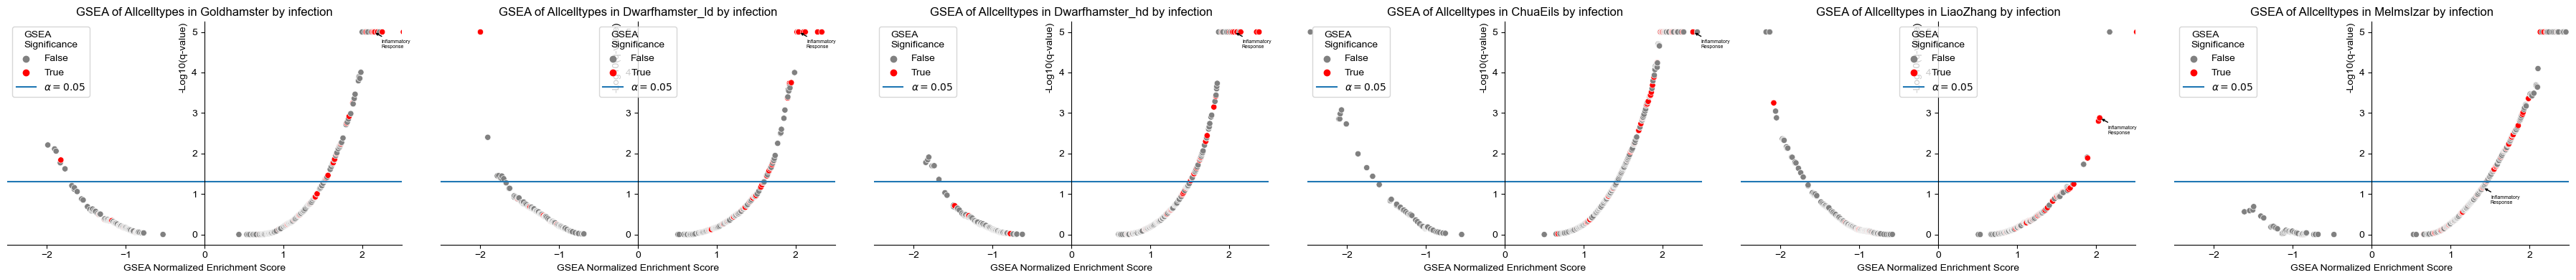

In [81]:
scale = 1
axs = pl.subplots(1, N, figsize=(6*N*scale,4*scale), sharey=False)[-1]
for i, ax in enumerate(axs):
    Uplot(pre_res[i], ax=ax)
    ax.set_title(f'GSEA of {celltype} in {datasets[i]} by infection')
pl.tight_layout()
pl.savefig(figure_path / 'FigS1E_wide.pdf', bbox_inches='tight')
pl.show()

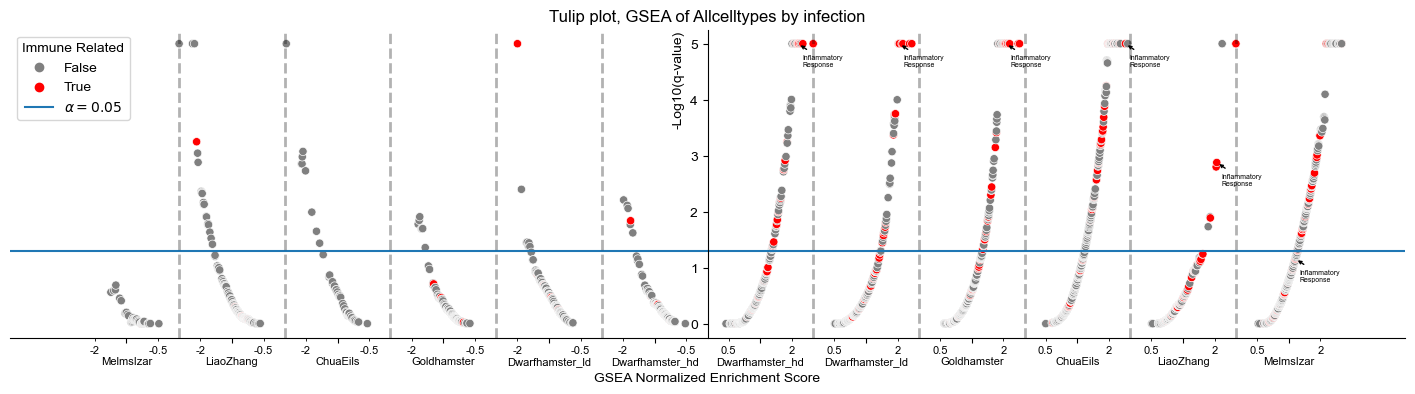

In [82]:
celltype='Allcelltypes'

datasets=['Dwarfhamster_hd', 'Dwarfhamster_ld', 'Goldhamster', 'ChuaEils', 'LiaoZhang', 'MelmsIzar']
N = len(datasets)
scale = 1
x_axis_offset = 2.5
ax = pl.subplots(1, 1, figsize=(3*N*scale,4*scale), sharey=False)[-1]
for i in range(N):
    # Uplot(pre_res[i], ax=ax, legend=i==N-1)
    legend=i==N-1
    prerank_object = pre_res[i]
    gene_sets=["KEGG_2021_Human", 'MSigDB_Hallmark_2020']
    ax = pl.subplots(figsize=(8,6))[-1] if ax is None else ax
    
    Y = extract_gsea_results(prerank_object, gene_sets)
    Y['NES'] = np.clip(Y.NES, -x_axis_offset, x_axis_offset)
    Y['NES']+=(2*(Y.NES>0)-1)*x_axis_offset*i
    
    # annotate with arrow
    x = Y[Y.Term=='MSigDB_Hallmark_2020__Inflammatory Response'].NES
    y = Y[Y.Term=='MSigDB_Hallmark_2020__Inflammatory Response'].score
    ax.annotate('Inflammatory\nResponse', (x, y), xytext=(x+0.1, y-0.4), arrowprops=dict(arrowstyle="->",
                        connectionstyle="arc3"), fontsize=5)
    
    sns.scatterplot(data=Y, x='NES', y='score', ax=ax, hue='immune_related', palette=['grey', 'red'], legend=legend)
                    #hue='source', hue_order=np.sort(Y.source.unique()))
    
    xmax = x_axis_offset*(N)*1.1
    ax.set_xlim(-xmax, xmax)
    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position('center')
    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    
    if legend:
        ax.axhline(-np.log10(0.05), label=r'$\alpha=0.05$')
        ax.legend(title='Immune Related')#, bbox_to_anchor=(1,0.5))

    ax.set_xlabel(f'GSEA Normalized Enrichment Score')
    ax.set_ylabel('-Log10(q-value)', loc='top')
ax.set_title(f'Tulip plot, GSEA of {celltype} by infection')
ax.set_xticks(list(-(np.arange(1, N+1) - 0.5)*x_axis_offset) + 
              list((np.arange(1, N+1) - 0.5)*x_axis_offset),
              minor=False)
ax.set_xticklabels(list(datasets) + list(datasets), fontsize=8, minor=False)
ax.tick_params(axis='x', which='major', pad=10)
for i in range(1, N):
    ax.axvline(x_axis_offset*i, c='black', linestyle='--', linewidth=2, alpha=0.3)
    ax.axvline(-x_axis_offset*i, c='black', linestyle='--', linewidth=2, alpha=0.3)
ax.set_xticks(
    sorted(list(-(np.arange(1, N+1))*x_axis_offset + 0.5) + list(-(np.arange(1, N+1))*x_axis_offset + 2.0)) + \
    sorted(list((np.arange(1, N+1))*x_axis_offset - 0.5) + list((np.arange(1, N+1))*x_axis_offset - 2.0))
              , minor=True)
ax.set_xticklabels([-2, -0.5]*N + [0.5, 2]*N, fontsize=8, minor=True)
pl.savefig(figure_path / 'FigS1E_halfboth.pdf', bbox_inches='tight')
pl.show()

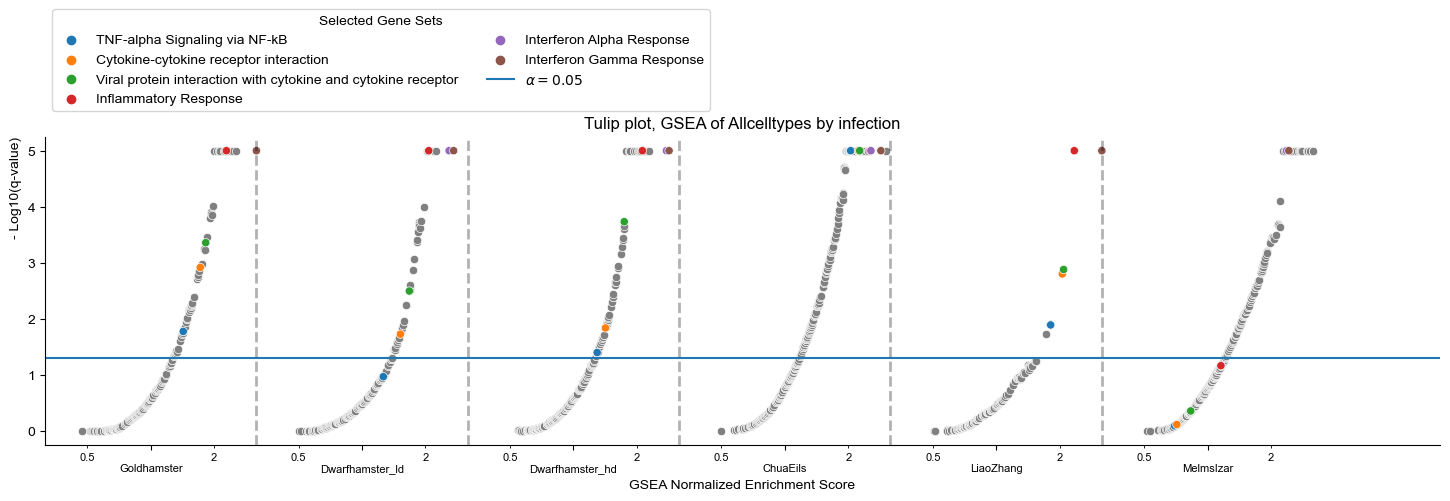

In [98]:
celltype='Allcelltypes'

keys = ['MSigDB_Hallmark_2020__Inflammatory Response',
        'MSigDB_Hallmark_2020__Interferon Alpha Response',
        'MSigDB_Hallmark_2020__Interferon Gamma Response',
        'KEGG_2021_Human__Cytokine-cytokine receptor interaction',
        'MSigDB_Hallmark_2020__TNF-alpha Signaling via NF-kB',
        'KEGG_2021_Human__Viral protein interaction with cytokine and cytokine receptor'
        ]

datasets=['Goldhamster', 'Dwarfhamster_ld', 'Dwarfhamster_hd', 'ChuaEils', 'LiaoZhang', 'MelmsIzar']
N = len(datasets)
scale = 1
x_axis_offset = 2.5
ax = pl.subplots(1, 1, figsize=(3*N*scale,4*scale), sharey=False)[-1]
for i in range(N):
    # Uplot(pre_res[i], ax=ax, legend=i==N-1)
    legend=i==N-1
    prerank_object = pre_res[i]
    gene_sets=["KEGG_2021_Human", 'MSigDB_Hallmark_2020']
    ax = pl.subplots(figsize=(8,6))[-1] if ax is None else ax
    
    Y = extract_gsea_results(prerank_object, gene_sets)
    Y = Y[Y['NES'] > 0]
    Y['NES'] = np.clip(Y.NES, -x_axis_offset, x_axis_offset)
    Y['NES']+=(2*(Y.NES>0)-1)*x_axis_offset*i
    
    Y['temp'] = [key.split('_')[-1] if key in keys else 'other' for key in Y.Term]
    
    # annotate with arrow
    # for key in keys:
    #     x = Y[Y.Term==key].NES
    #     y = Y[Y.Term==key].score
    #     ax.annotate(key, (x, y), xytext=(x+0.1, y-0.4), arrowprops=dict(arrowstyle="->",
    #                         connectionstyle="arc3"), fontsize=5)
    scatter_kwargs = dict(x='NES', y='score', ax=ax, legend=legend)
    sns.scatterplot(data=Y[Y.temp=='other'], color='grey', **scatter_kwargs)
    sns.scatterplot(data=Y[Y.temp!='other'], hue='temp', **scatter_kwargs)
    
    xmax = x_axis_offset*(N)*1.1
    ax.set_xlim(0, xmax)
    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    
    if legend:
        ax.axhline(-np.log10(0.05), label=r'$\alpha=0.05$')
        ax.legend(title='Selected Gene Sets')#, bbox_to_anchor=(1,0.5))
        sns.move_legend(ax, "lower left", bbox_to_anchor=(0.0, 1.06), ncol=2)

    ax.set_xlabel(f'GSEA Normalized Enrichment Score')
    ax.set_ylabel('- Log10(q-value)', loc='top')
ax.set_title(f'Tulip plot, GSEA of {celltype} by infection')
ax.set_xticks(list((np.arange(1, N+1) - 0.5)*x_axis_offset),
              minor=False)
ax.set_xticklabels(list(datasets), fontsize=8, minor=False)
ax.tick_params(axis='x', which='major', pad=10)
for i in range(1, N):
    ax.axvline(x_axis_offset*i, c='black', linestyle='--', linewidth=2, alpha=0.3)
ax.set_xticks(
    sorted(list((np.arange(1, N+1))*x_axis_offset - 0.5) + list((np.arange(1, N+1))*x_axis_offset - 2.0))
              , minor=True)
ax.set_xticklabels([0.5, 2]*N, fontsize=8, minor=True)
pl.savefig(figure_path / 'FigS1E.pdf', bbox_inches='tight')
pl.show()

### Jaccard sim between sig gene sets across datasets (GSEA similarity)

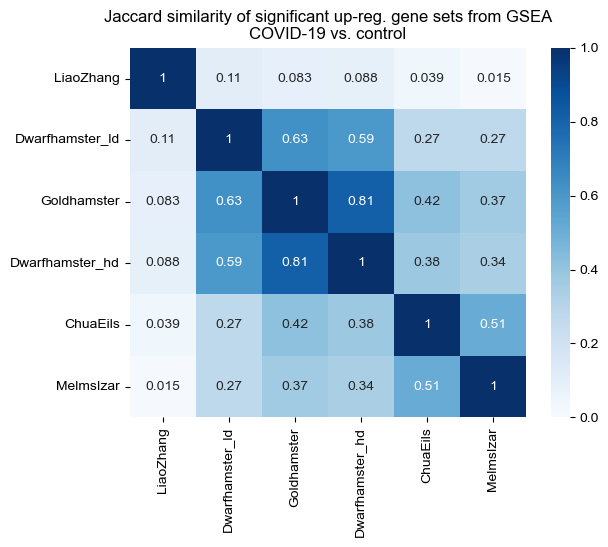

In [6]:
# Compute Jaccard similarity between the significant gene sets in each dataset
datasets=['Goldhamster', 'Dwarfhamster_ld', 'Dwarfhamster_hd', 'ChuaEils', 'LiaoZhang', 'MelmsIzar']
N = len(datasets)
M = pd.DataFrame(np.zeros((N, N)), index=datasets, columns=datasets)
gene_sets=["KEGG_2021_Human", 'MSigDB_Hallmark_2020']
for i in range(N):
    for j in range(N):
        Y1 = extract_gsea_results(pre_res[i], gene_sets)
        Y2 = extract_gsea_results(pre_res[j], gene_sets)
        Y1 = Y1[(Y1.NES>0) & (Y1['FDR q-val'] < 0.05)]
        Y2 = Y2[(Y2.NES>0) & (Y2['FDR q-val'] < 0.05)]
        if len(Y1) * len(Y2) == 0:
            continue
        M.iloc[i, j] = len(set(Y1.Term) & set(Y2.Term)) / \
                  len(set(Y1.Term) | set(Y2.Term))

sns.heatmap(cluster_matrix(M, 'both'), annot=True, cmap='Blues', vmin=0, vmax=1)
pl.title('Jaccard similarity of significant up-reg. gene sets from GSEA\nCOVID-19 vs. control')
pl.savefig(figure_path / 'Jaccard_similarity_GSEA_upregulated_infection.pdf', bbox_inches='tight')
pl.show()

### Heatmaps, Dotplots and such (Fig1E)

In [8]:
# prepare NES and p-value score tables for plotting
order = list(['Goldhamster', 'Dwarfhamster_ld', 'Dwarfhamster_hd', 'ChuaEils', 'LiaoZhang', 'MelmsIzar'])
NES_df = pd.pivot_table(Ls, index='Term', columns='dataset', values='NES')[order]
score_df = pd.pivot_table(Ls, index='Term', columns='dataset', values='score')[order]
# cleanup names
NES_df.columns = [sanitize_name(x) for x in NES_df.columns]
NES_df.index = [x.split('_')[-1] for x in NES_df.index]
score_df.columns = [sanitize_name(x) for x in score_df.columns]
score_df.index = [x.split('_')[-1] for x in score_df.index]

In [9]:
from matplotlib.collections import PatchCollection
def plot_dotplot(NES_df, score_df, keys, ax=None, flip_xy=False, xrotation=45):
       if flip_xy:
              color = NES_df.loc[keys]
              size = score_df.loc[keys]
              M, N = color.shape
       else:
              color = NES_df.loc[keys].T
              size = score_df.loc[keys].T
              N, M = color.shape

       x, y = np.meshgrid(np.arange(M), np.arange(N))
       s = size.values.astype(int)
       c = color.values.astype(float)

       ax = pl.subplots()[1] if ax is None else ax
       
       R_min = 0.2
       R = s/s.max()/2 * (0.6 - R_min) + R_min * (s>0)
       circles = [pl.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
       col = PatchCollection(circles, array=c.flatten(), cmap="bwr")
       col.set_clim(-2.5, 2.5)
       ax.add_collection(col)

       ax.set(xticks=np.arange(M), yticks=np.arange(N),
              xticklabels=color.columns, yticklabels=color.index)
       ax.set_xticks(np.arange(M+1)-0.5, minor=True)
       ax.set_xticklabels(color.columns, rotation=xrotation, ha='right')
       ax.set_yticks(np.arange(N+1)-0.5, minor=True)
       ax.set_yticklabels(color.index)
       ax.grid(which='minor')
       ax.set_aspect('equal')
       ax.set_title('GSEA of All cell types by infection\nSize: score (neglog10 of pvalue)')
       pl.gcf().colorbar(col, ax=ax, label='NES', pad=0.05, aspect=10, shrink=0.25)


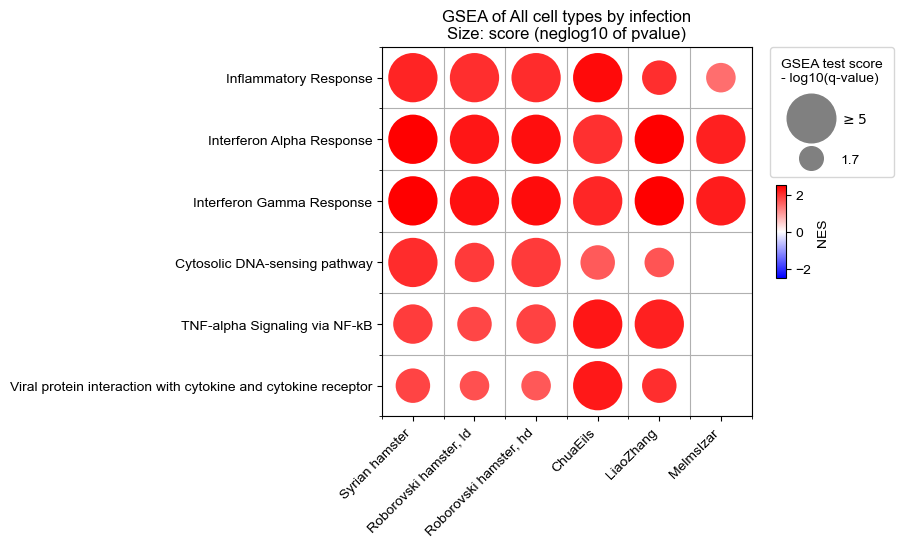

In [71]:
keys = ['Inflammatory Response',
        'Interferon Alpha Response',
        'Interferon Gamma Response',
        'Cytosolic DNA-sensing pathway',
        'TNF-alpha Signaling via NF-kB',
        'Viral protein interaction with cytokine and cytokine receptor'
        ]
plot_dotplot(NES_df, score_df, keys[::-1], flip_xy=True)

scores = np.ravel(score_df.loc[keys].values)
scores = scores[scores >= -np.log10(0.05)]
smallest_score = scores.min()

from matplotlib.lines import Line2D
circ_max = Line2D([], [], color="grey", marker='o', markersize=35, markerfacecolor="grey", label = r"$\geq 5$", linewidth=0)
circ_min = Line2D([], [], color="grey", marker='o', markersize=17, markerfacecolor="grey", label = np.round(smallest_score, 1), linewidth=0)
pl.gca().legend(handles=[circ_max, circ_min], bbox_to_anchor=(1.05, 1), loc='upper left',
                borderaxespad=0., labelspacing=2, borderpad=0.8, handletextpad=1.1, title='GSEA test score\n- log10(q-value)')

pl.savefig(figure_path / 'GSEA_selected_cherry_dotplot.pdf', bbox_inches='tight')
pl.show()

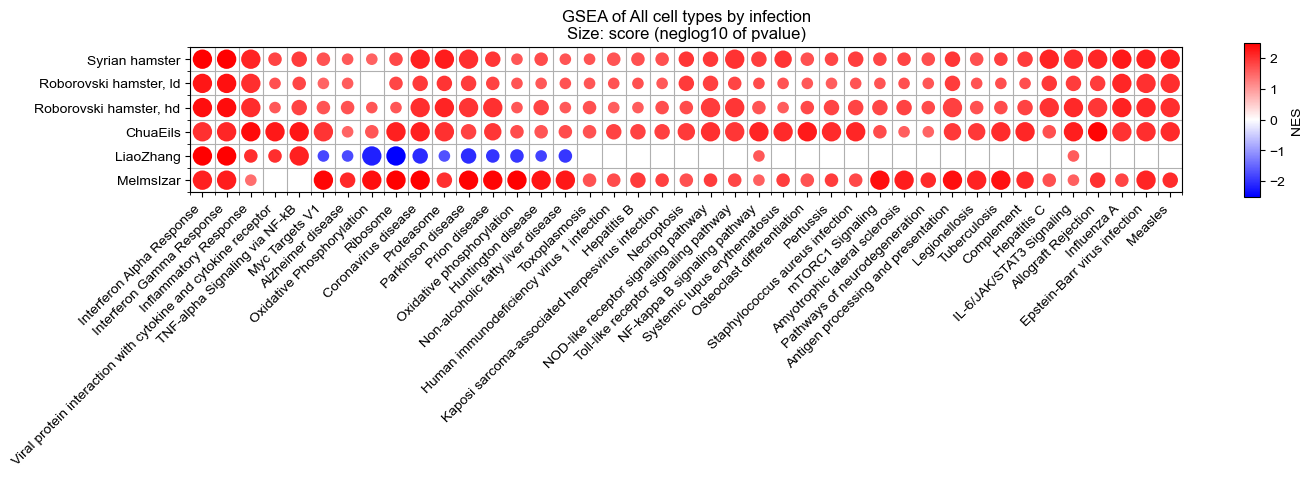

In [20]:
# only keep terms that are found in more than X datasets
summary = Ls[Ls['FDR q-val']<0.05].groupby(['dataset', 'Term'])['NES'].aggregate('mean').unstack().fillna(0)
summary = cluster_matrix(summary, how='col').T
summary.index = [x.split('_')[-1] for x in summary.index]
S = summary[np.sum(summary!=0, axis=1) > 4]

fig, ax = pl.subplots(figsize=(16, 8))
plot_dotplot(NES_df, score_df, list(S.index), ax=ax)
pl.savefig(figure_path / 'GSEA_big_cherry_dotplot.pdf', bbox_inches='tight')
pl.show()

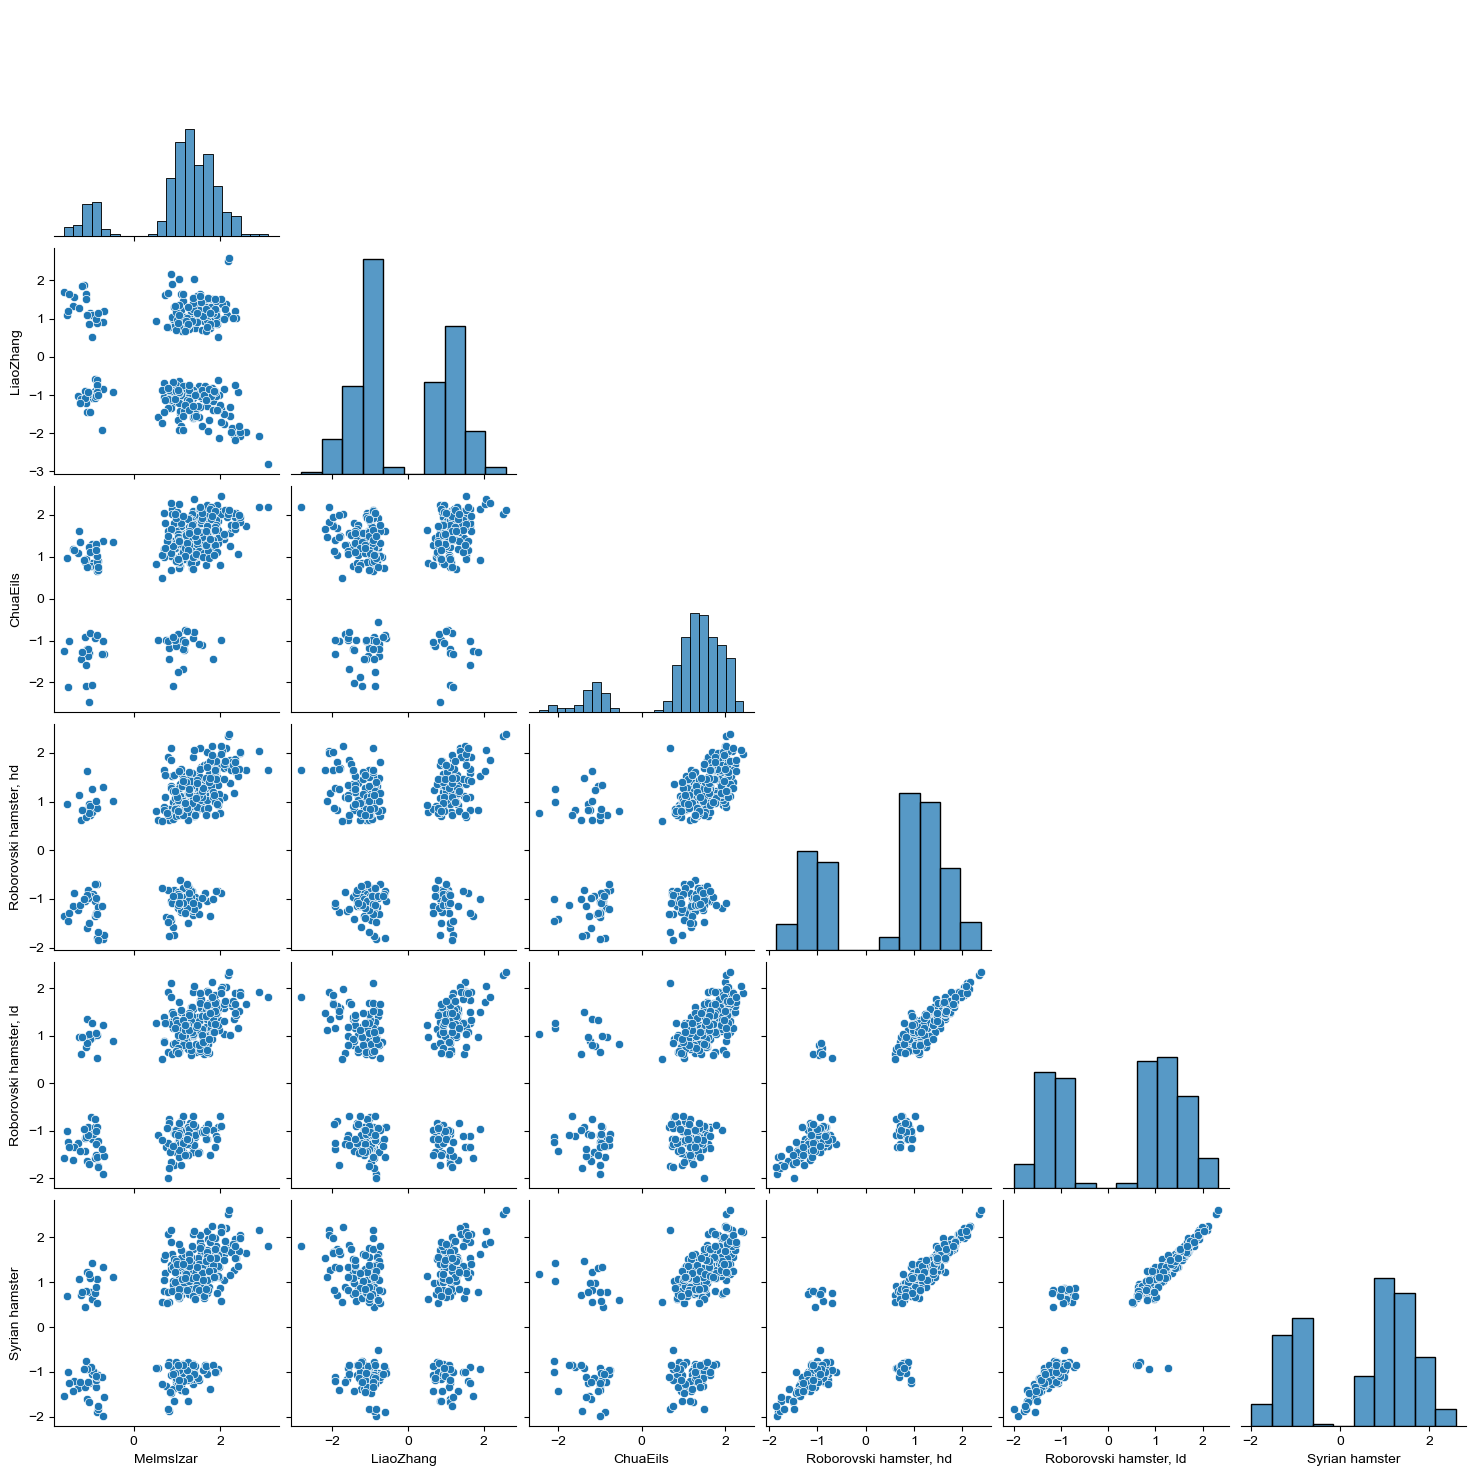

In [29]:
sns.pairplot(NES_df[~NES_df.index.duplicated(keep='first')], corner=True)

In [30]:
top_keys = NES_df.sum(1).sort_values(ascending=False).index[:20]

In [31]:
# Let's aggregate scores using the same manual gene set annotation
# as used for the Endos
manual_annotation = {
    'mTORC1 Signaling': 'Protein regulation',
    'Proteasome': 'Protein regulation',
    'Aminoacyl-tRNA biosynthesis': 'Protein regulation',
    'Ribosome': 'Ribosome',
    'Viral protein interaction with cytokine and cytokine receptor': 'Viral protein interaction with\ncytokine and cytokine receptor',
    'IL-6/JAK/STAT3 Signaling': 'IL-6/JAK/STAT3 Signaling',
    'Allograft Rejection': 'Allograft Rejection',
    'Inflammatory Response': 'TNF inflammatory response',
    'TNF-alpha Signaling via NF-kB': 'TNF inflammatory response',
    'TNF signaling pathway': 'TNF inflammatory response',
    'Interferon Gamma Response': 'Interferon response',
    'Interferon Alpha Response': 'Interferon response',
    'Hepatitis C': 'Virus infection',
    'Measles': 'Virus infection',
    'Influenza A': 'Virus infection',
    'Herpes simplex virus 1 infection': 'Virus infection',
    'Epstein-Barr virus infection': 'Virus infection',
    'RIG-I-like receptor signaling pathway': 'Virus sensing pathways',
    'Cytosolic DNA-sensing pathway': 'Virus sensing pathways',
    'Diabetic cardiomyopathy': 'OxPhos',
    'Oxidative phosphorylation': 'OxPhos',
    'Retrograde endocannabinoid signaling': 'OxPhos'
}

In [33]:
NES_df_ = NES_df.loc[top_keys].copy()
score_df_ = score_df.loc[top_keys].copy()
NES_df_['gs'] = [manual_annotation[x] if x in manual_annotation.keys() else x for x in NES_df_.index]
score_df_['gs'] = [manual_annotation[x] if x in manual_annotation.keys() else x for x in score_df_.index]
NES_df_ = NES_df_.fillna(0).groupby('gs').mean()
score_df_ = score_df_.fillna(0).groupby('gs').mean()

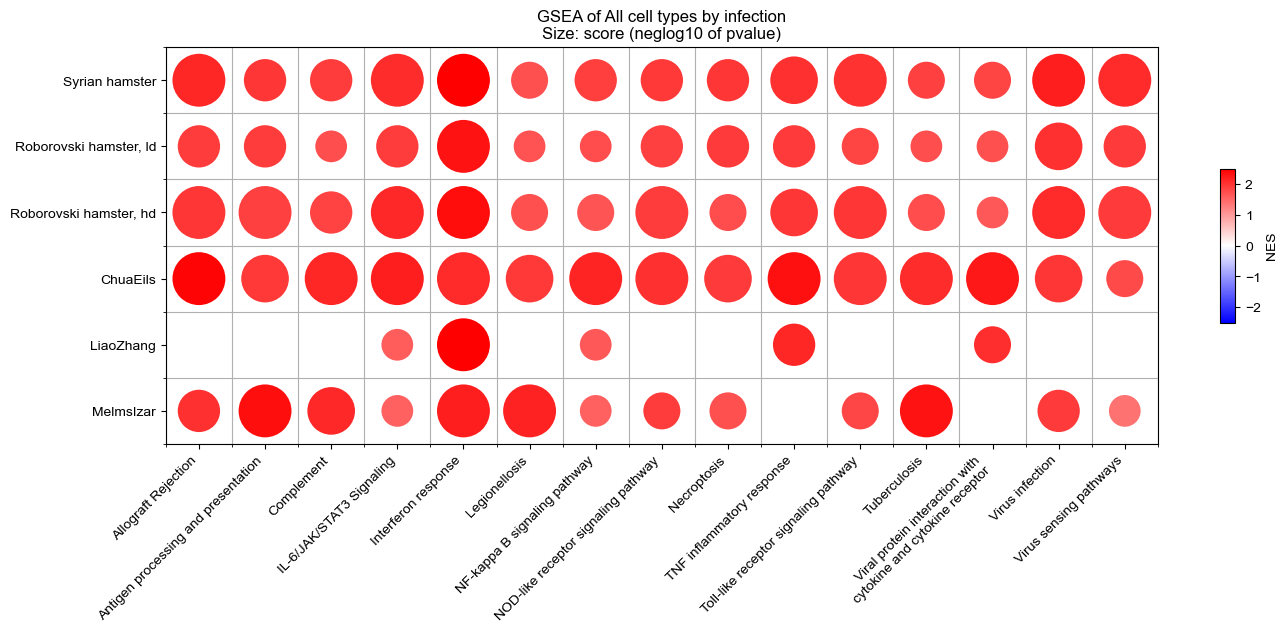

In [35]:
fig, ax = pl.subplots(figsize=(16, 8))
plot_dotplot(NES_df_, score_df_, NES_df_.index, ax=ax)
pl.show()